In [1]:
#PROBLEM! Bmad strips the IDs
# P = modifyAndSaveInputBeam(
#     inputBeamFilePath,
#     timeCenterTF = True);
# P.id
# array([1248183., 2994706., 2511880., ..., 2072128., 2829025., 2503797.])

# P = ParticleGroup(data=tao.bunch_data('L0AFEND'))
# P.id
# array([     1,      2,      3, ...,  99998,  99999, 100000])

#I'm going to deal with this by creating a new input file where the witness and driver particles have very, very slightly different weights
#Bmad (presumably...) retains weight data
# tao.bunch_data('L0AFEND')
# {'x': array([-0.00195192,  0.00030864, -0.0004523 , ..., -0.00071584,
#          0.00193254,  0.00020216]),
#  'px': array([-4420.96969495,  -685.02317667,   133.48213397, ...,
#          -342.74119023,  -922.60208893,   108.49622748]),
#  'y': array([ 8.59443329e-04, -2.54455833e-04,  1.89575995e-04, ...,
#          5.65670775e-04, -8.43240229e-05,  5.80456205e-04]),
#  'py': array([7467.50791431,  -33.53628711,  566.19673442, ..., 1441.97856318,
#         -143.50800545, 1806.11092054]),
#  't': array([-5.17371712e-12,  1.69013303e-12,  2.60064835e-13, ...,
#         -1.00286780e-12,  1.29688271e-12,  2.12125643e-13]),
#  'pz': array([65293100.65247   , 66168140.85241183, 66168857.13704683, ...,
#         66197878.14223742, 66172382.71861624, 66170620.39594007]),
#  'status': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
#  'weight': array([2.09820918e-14, 2.09820918e-14, 2.09820918e-14, ...,
#         2.09820918e-14, 2.09820918e-14, 2.09820918e-14]),
#  'z': array([0, 0, 0, ..., 0, 0, 0]),
#  'species': 'electron'}
;

''

In [2]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

from plotNMM import plotNMM, slicePlotNMM
from IPython.display import display

#needed for lattice_init
#%env FACET2_LATTICE /u/ar/dcesar/notebooks/facet_bmad
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


In [3]:
def modifyAndSaveInputBeam(
    inputBeamFilePath,
    betaX = None,
    alphaX = None,
    betaY = None,
    alphaY = None,
    numMacroParticles = None,
    timeCenterTF = True):

    #Import
    P = ParticleGroup(inputBeamFilePath)

    #Downsample
    if numMacroParticles:
        P.data.update(resample_particles(P, n=numMacroParticles))

    #Time center
    if timeCenterTF:
        P.t=P.t-np.mean(P.t) #This is OK because present beam doesn't have different weights; np.unique(P.weight)

    #Apply linear matching
    if (betaX is not None) and (alphaX is not None):
        P.twiss_match(
              plane='x',
              beta = betaX,
              alpha = alphaX,
              inplace=True)

    if (betaY is not None) and (alphaY is not None):
        P.twiss_match(
              plane='y',
              beta = betaY,
              alpha = alphaY,
              inplace=True)

    #Write as the active file
    P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

    #Also return the beam object
    return P

In [4]:
inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample.h5'
outputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5'

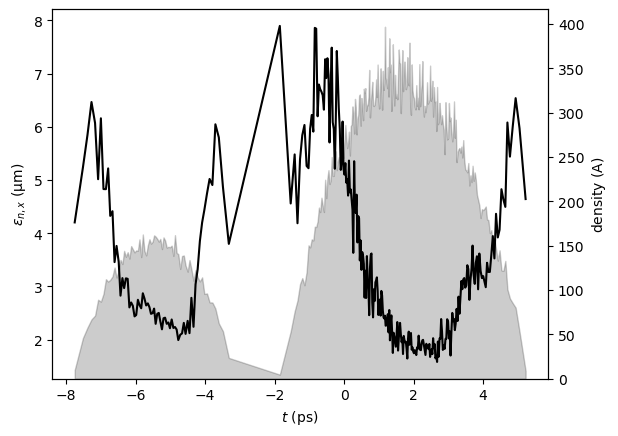

Num driver / witness macroparticles: 76267 / 23733


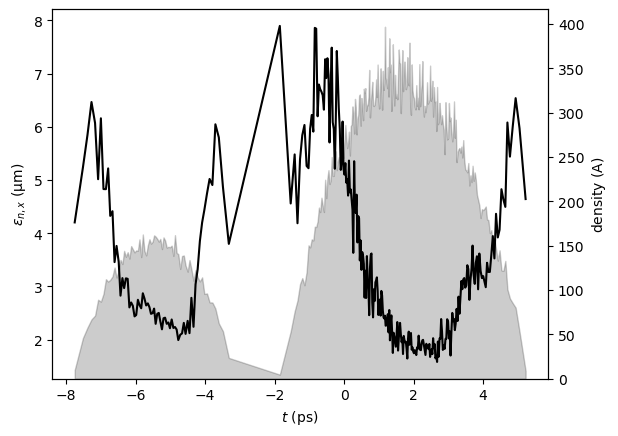

In [5]:
#This stuff is hardcoded, beware!

P = modifyAndSaveInputBeam(
    inputBeamFilePath,
    timeCenterTF = True);

display(slicePlotNMM(P, 'norm_emit_x', n_slice = 300, slice_key = "t"))

#By eye, pick the dividing line
witnessDriverSplitDeltaT = -3e-12

witnessIDs = P[P.t < witnessDriverSplitDeltaT].id
driverIDs = P[P.t > witnessDriverSplitDeltaT].id

print(f"Num driver / witness macroparticles: {np.size(driverIDs)} / {np.size(witnessIDs)}")

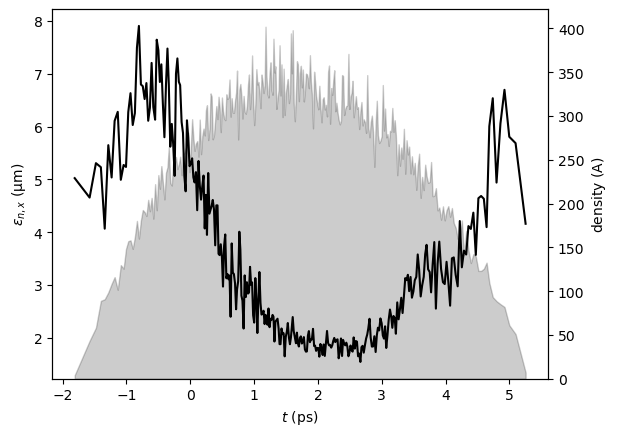

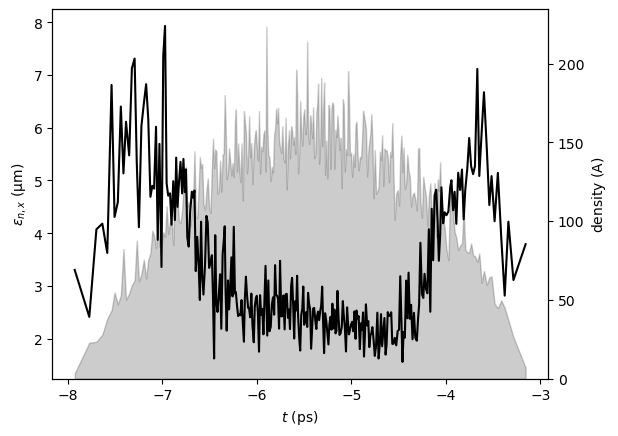

In [6]:
driverSubset = P[ np.isin(P.id, driverIDs) ]
witnessSubset = P[ np.isin(P.id, witnessIDs) ]

display(slicePlotNMM(driverSubset, 'norm_emit_x', n_slice = 300, slice_key = "t"))
display(slicePlotNMM(witnessSubset, 'norm_emit_x', n_slice = 300, slice_key = "t"))

In [7]:
startingWeight = P.weight[0]
startingWeight

witnessWeight = 0.999*startingWeight
driverWeight = 1.001*startingWeight

In [8]:
np.unique(P.weight)

array([2.09820918e-14])

In [9]:
newWeightArr = np.full(np.size(P.weight), -1.1)
for i in range(np.size(newWeightArr)):
    if P.t[i] < witnessDriverSplitDeltaT:
        newWeightArr[i] = witnessWeight
    else:
        newWeightArr[i] = driverWeight

In [10]:
P.weight = newWeightArr

In [11]:
np.unique(P.weight)

array([2.09611097e-14, 2.10030739e-14])

In [12]:
P.write(outputBeamFilePath)

In [13]:
del P 

#Now load in the new file to check it

P2 = ParticleGroup(outputBeamFilePath)
np.unique(P2.weight)

array([2.09611097e-14, 2.10030739e-14])